## Setup: Import libraries for sentiment and thematic analysis

In [21]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji
import sys
import os
sys.path.append(os.path.abspath('..'))
from scripts.task2_helper_functions import SentimentAnalysis, ThematicAnalysis, clean_text, handle_missing_values

In [22]:
sentiment_analysis = SentimentAnalysis()
thematic_analysis = ThematicAnalysis()

In [32]:
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon') # Download the VADER lexicon 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
sid = SentimentIntensityAnalyzer()

## Load cleaned banks datasets

In [3]:
df_boa = pd.read_csv('../data/boa_cleaned.csv', parse_dates=['date'])
df_cbe = pd.read_csv('../data/cbe_cleaned.csv', parse_dates=['date'])
df_dashen = pd.read_csv('../data/dashen_cleaned.csv', parse_dates=['date'])
df = pd.concat([df_boa, df_cbe, df_dashen])
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   1200 non-null   int64         
 1   review  1200 non-null   object        
 2   rating  1200 non-null   int64         
 3   source  1200 non-null   object        
 4   date    1200 non-null   datetime64[ns]
 5   bank    1200 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 56.4+ KB


## 1- Sentiment Analysis

In [14]:
# Function to clean each review
def clean_text(text):
    if pd.isnull(text):
        return ""
    
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')  # removes all emojis
    
    # Remove non-ASCII characters (Amharic, etc.)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Remove non-alphanumeric characters (except basic punctuation)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'"-]', ' ', text)

    # Keep only letters and whitespace
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.lower()
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [4]:
df['cleaned_review'] = df['review'].apply(clean_text)


In [16]:
def get_sentiment(text):
    """
    Compute sentiment for a given text.
    Returns:
      sentiment_label: 'positive', 'neutral', or 'negative'
      sentiment_score: compound score as a float
    """
    scores = sid.polarity_scores(text)
    compound = scores['compound']
    # Define thresholds for sentiment labels
    if compound >= 0.05:
        label = 'positive'
    elif compound <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return label, compound


In [5]:
df[['sentiment_label', 'sentiment_score']] = df['review'].apply(lambda x: pd.Series(sentiment_analysis.get_sentiment(x)))

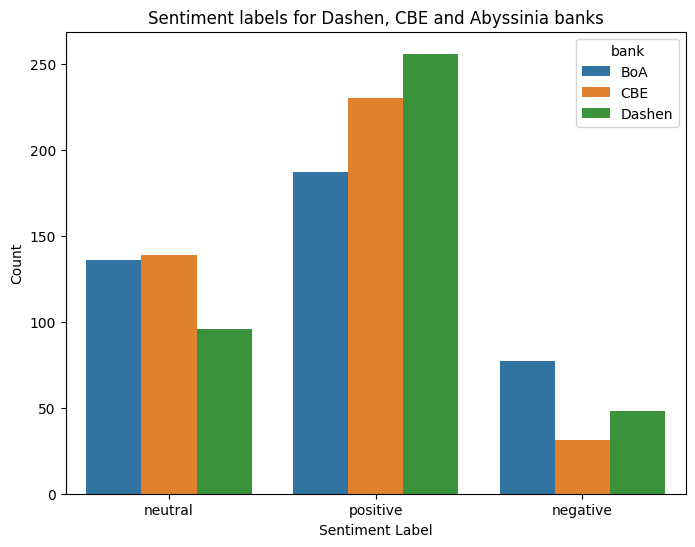

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='sentiment_label', hue='bank')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment labels for Dashen, CBE and Abyssinia banks')
plt.show()

In [19]:
"""
Preprocessing includes lemmatization and stopword removal, 
which improves keyword extraction quality.
"""
def preprocess_text(text):
    """
    Preprocess the input text:
    - Lowercase
    - Remove stopwords
    - Lemmatize
    - Keep only alphabetic tokens
    """
    # Check if the input is a string
    if not isinstance(text, str):
        return ""
    
    # Use spaCy to process the text
    doc = nlp(text.lower())
    
    # Token filtering: remove stopwords and non-alphabetic tokens, apply lemmatization
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    # Join tokens back to a string
    return " ".join(tokens)

In [9]:
# Create a new column with cleaned text
df['cleaned_review'] = df['review'].apply(sentiment_analysis.preprocess_text)

In [10]:
df[['review', 'cleaned_review']].head(30) ## comparing review and cleaned_review after transformation


,review,cleaned_review
0,🙏👍,
1,Very Good,good
2,goof,goof
3,good!,good
4,good jop,good jop
5,bad exprience...it is so crushed,bad exprience crushed
6,not user friendly at all it requires a huge co...,user friendly require huge connectivity lag time
7,ምንም የማይ ሰራ,ምንም የማይ ሰራ
8,very good,good
9,most of the time is not working properly,time work properly


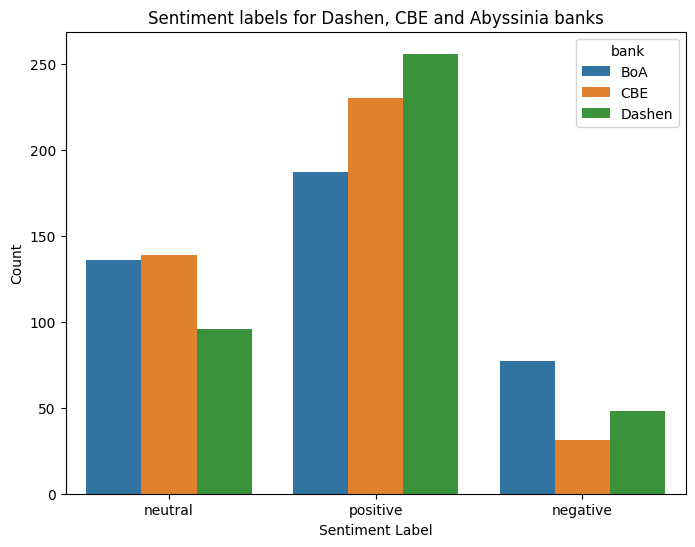

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='sentiment_label', hue='bank')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment labels for Dashen, CBE and Abyssinia banks')
plt.show()

In [12]:
df.to_csv('../data/cleaned_data.csv')

## 2- Thematic Analysis on the dataset

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load your cleaned CSV which contains the critical 'review' column
df = pd.read_csv('../data/cleaned_data.csv')
# Define a mapping from keywords to themes
theme_mapping = {
    'stability': ['crash', 'freeze', 'error'],
    'performance': ['slow', 'lag', 'delay'],
    'ui': ['ui', 'interface', 'design'],
    'support': ['support', 'help', 'service']
}
def handle_missing_values(text):
    if pd.isna(text):
        return ''
    else:
        return text
# Step 1: Use TF-IDF Vectorizer to extract important keywords from each review
def extract_keywords(reviews, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(reviews)
    features = np.array(vectorizer.get_feature_names_out())
    keywords_list = []
    for idx in range(X.shape[0]):
        weights = X[idx].toarray().ravel()
        top_idx = weights.argsort()[-top_n:]
        keywords_list.append(features[top_idx])
    return keywords_list

# Step 2: Cluster the reviews into themes using KMeans
def assign_theme(keywords_list):
    themes = []
    for keywords in keywords_list:
        found_themes = set()
        for theme, key_terms in theme_mapping.items():
            if any(term in keywords for term in key_terms):
                found_themes.add(theme)
        themes.append(', '.join(found_themes) if found_themes else 'General')
    return themes


In [17]:
df['cleaned_review'] = df['cleaned_review'].apply(handle_missing_values)

In [23]:
keywords = thematic_analysis.extract_keywords(df['cleaned_review'])
df['identified_theme'] = thematic_analysis.assign_theme(keywords)

print(df[['cleaned_review', 'identified_theme']])

AttributeError: 'ThematicAnalysis' object has no attribute 'extract_keywords'

In [ ]:
df.head()

,Unnamed: 0,index,review,rating,source,date,bank,cleaned_review,sentiment_label,sentiment_score,identified_theme
0,0,0,🙏👍,5,Google Play,2025-11-29,BoA,,neutral,0.0000,General
1,1,1,Very Good,5,Google Play,2025-11-28,BoA,good,positive,0.4927,General
2,2,2,goof,5,Google Play,2025-11-28,BoA,goof,neutral,0.0000,General
3,3,3,good!,5,Google Play,2025-11-28,BoA,good,positive,0.4926,General
4,4,4,good jop,5,Google Play,2025-11-27,BoA,good jop,positive,0.4404,General


In [ ]:
# Step 3: Export the DataFrame with the theme labels to a new CSV file
df.to_csv('../data/cleaned_themed_reviews.csv', index=False)

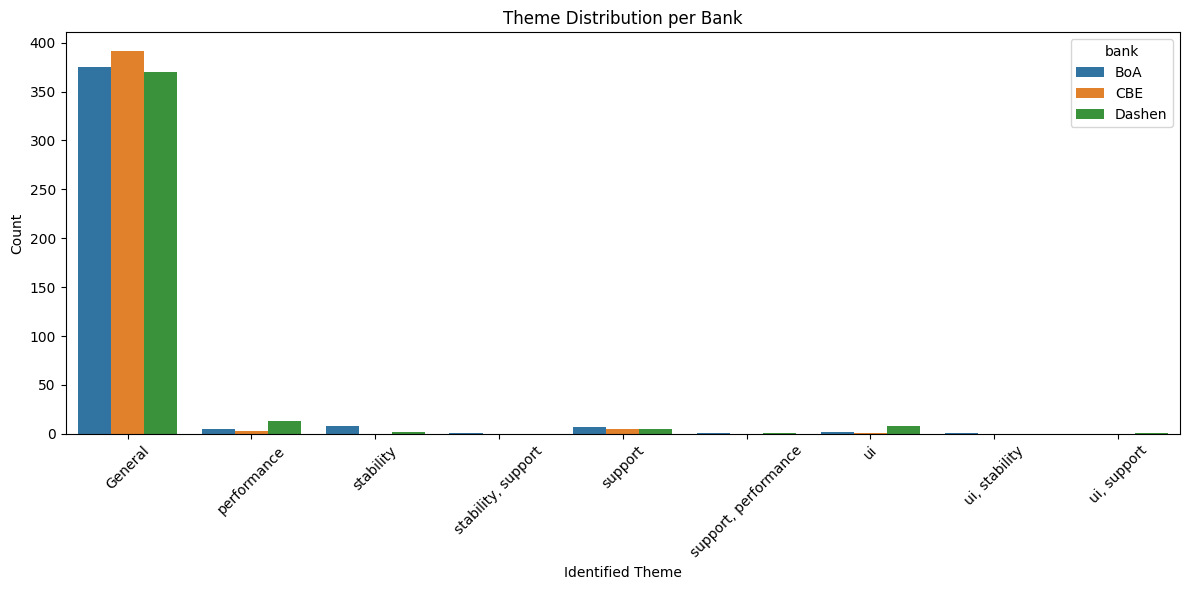

In [ ]:
theme_counts = df.groupby(['bank', 'identified_theme']).size().reset_index(name='counts')

# Visualize with a bar plot
plt.figure(figsize=(12,6))
sns.barplot(data=theme_counts, x='identified_theme', y='counts', hue='bank')
plt.title("Theme Distribution per Bank")
plt.xlabel("Identified Theme")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()